In [22]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

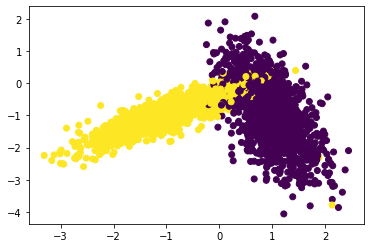

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

In [24]:
X_train.shape

(7500, 2)

# Implementing Custom RandomSearchCV

In [25]:
def RandomSearchCV(x_train_raw, y_train_raw, classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model

    # 1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    random_values = sorted(random.sample(range(1, param_range), 10))
    params = {'n_neighbors': random_values}

    # 2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
    # group 1: 0-33, group 2:34-66, group 3: 67-100
    group = int(len(x_train_raw) / folds) #2500
    # print(group)
    

    # 3.for each hyperparameter that we generated in step 1:
    # and using the above groups we have created in step 2 you will do cross-validation as follows
        
    # first we will keep group1+group2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
    # test accuracies
    # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
    # train and test accuracies
    # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
    # test accuracies
    # based on the 'folds' value we will do the same procedure
    # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
    # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    train_scores = []
    test_scores = []
    for k in tqdm(params['n_neighbors']):
        train_scores_folds = []
        test_scores_folds = []
        for i in range(0, folds):
            # computing test indices first and then doing set subtraction to find out the train indices
            test_indices = list(set(list(range((group*i), (group*(i+1))))))
            # print('test_indices ', test_indices)

            # And the whole rest of the indices of the dataset will be the train_indices
            train_indices = list(set(list(range(0, len(x_train_raw)))) - set(test_indices) )
            # print('train_indices ', train_indices)


            # selecting the data points based on the train_indices and test_indices
            X_train = x_train_raw[train_indices]
            Y_train = y_train_raw[train_indices]
            X_test = x_train_raw[test_indices]
            Y_test = y_train_raw[test_indices]
            
            classifier.n_neighbors = k
            classifier.fit(X_train, Y_train)

            y_predicted = classifier.predict(X_test)
            test_scores_folds.append(accuracy_score(Y_test, y_predicted))

            y_pred = classifier.predict(X_train)
            train_scores_folds.append(accuracy_score(Y_train, y_pred))

        train_scores.append(np.mean(np.array(train_scores_folds)))
        test_scores.append(np.mean(np.array(test_scores_folds)))

    return train_scores, test_scores, params # here we have to return params also to use it on the plot

In [26]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()
param_range =  50
folds = 3

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) 
# and store the returned values into "train_scores", "train_scores", and "params"
test_scores, train_scores, params = RandomSearchCV(X_train, y_train, neigh, param_range, folds)


print('train scores are: ', train_scores)
print('='*100)
print('test scores are: ', test_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.02s/it]

train scores are:  [0.9296000000000001, 0.9518666666666666, 0.9544, 0.9541333333333334, 0.9538666666666668, 0.9546666666666667, 0.9557333333333333, 0.9561333333333333, 0.9556, 0.9565333333333333]
test scores are:  [1.0, 0.9608, 0.9588666666666666, 0.9575999999999999, 0.9573999999999999, 0.9575333333333332, 0.9575999999999999, 0.9579333333333334, 0.9579333333333334, 0.9579999999999999]


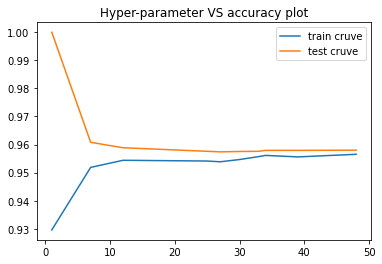

In [27]:
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
# Now plotting hyper-parameter vs accuracy plot to choose the best hyperparameter
plt.plot(params['n_neighbors'],train_scores, label='train cruve')
plt.plot(params['n_neighbors'],test_scores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [28]:
#7. plot the decision boundaries for the model initialized with the best hyperparameter, 
# as shown in the last cell of reference notebook
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

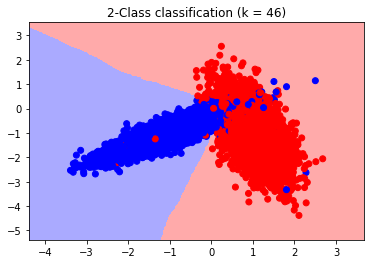

In [29]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 46)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)